In [25]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from numpy import linalg
from random import random
from copy import deepcopy
from scipy.linalg import hankel, eigh
from matplotlib import style
from matplotlib.patches import Ellipse
import seaborn as sns
from sklearn.cluster import KMeans
from models import rank

In [2]:
def calc_eigen(X_train):
  eigenValues, eigenVectors = eigh(np.matmul(X_train, X_train.T))
  idx = eigenValues.argsort()[::-1]
  eigenValues = eigenValues[idx]
  eigenVectors = eigenVectors[:,idx]
  return eigenValues,eigenVectors

In [3]:
def plot_eigen(eigenValues):
  fig, ax = plt.subplots(1, 1, figsize=(10,8))
  ax.plot(eigenValues)
  ax.set_title("Screeplot")
  ax.set_ylabel("Eigen value ->")
  ax.set_xlabel("Cardinal Number of Eigen value ->")

In [4]:
def signal_subspace_matrix(X_train,r,eigenVectors):
  # Extracted Training signals
  U, Sigma, V = np.linalg.svd(X_train)
  V = V.T
  X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,r)] )
  X_train_extracted = X_elem.sum(axis=0)
  X_train_extracted_data = np.asarray(list(X_train_extracted[:,0]) + list(X_train_extracted[:,-1]))
  U = eigenVectors[:,:r] # r as statistical dimension
  UT = U.T
  return X_train_extracted,U,UT

In [5]:
def final_X(M,UT):
  return np.matmul(UT,M)

In [6]:
def calc_centroid(X):
  col_max = np.amax(X,axis=0)
  col_min = np.amin(X,axis=0)
  print(col_min,col_max)
  centroid = (col_max + col_min)/2
  return centroid

In [7]:
def calc_Z(X,centroid):
  return (X-centroid)**2

In [8]:
def calc_h(alpha,Z):
  return np.matmul(alpha,Z)

In [9]:
def isclose(a, b, rel_tol, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [10]:
def calc_s(rows,cols,h,alpha_old,Z,u,i):
  ans=0
  for j in range(cols):
            s_i_j = h[j] - alpha_old[i]*Z[i][j]
            ans += (1/(u + s_i_j/Z[i][j]))
  return ans

In [11]:
def binary(rows,cols,h,alpha_old,Z,i,low,high):
  mid=(low+high)/2
  temp_ans=calc_s(rows,cols,h,alpha_old,Z,mid,i)
  while(not isclose(temp_ans,1,1e-05)):
    # print(abs(temp_ans-1))
    if(temp_ans>1):
      low=mid
    elif(temp_ans<1):
      high=mid
    else:
      return mid
    mid = (low+high)/2
    # print(low,high,mid)
    temp_ans=calc_s(rows,cols,h,alpha_old,Z,mid,i)
  return mid

In [12]:
def helper(rows,cols,h,alpha_old,Z,u,i):

    u_old=u 
    
    while(calc_s(rows,cols,h,alpha_old,Z,u,i)>1):
        u_old=u
        u*=2        
    if u_old == u:
        u = binary(rows,cols,h,alpha_old,Z,i,0,1)
    else:
        u =binary(rows,cols,h,alpha_old,Z,i,u_old,u)
    return u

In [13]:
def solution(rows,cols,Z,alpha,h,tol):
    i = 0
    updates = 0
    converged = False
    alpha_old = np.zeros(rows)
    old = 0
        
    while i < rows:
        if converged:
            return h,alpha
        alpha_old[i] = alpha[i]
        f_x = 0
        u=0
        f_x=calc_s(rows,cols,h,alpha_old,Z,u,i)
        
        if f_x == 1:
            alpha[i] = u
        
        if f_x < 1:

            alpha[i] = 0

        if f_x > 1:
            alpha[i]= helper(rows,cols,h,alpha_old,Z,1,i)
            
                
        h = h + (alpha[i] - alpha_old[i])*Z[i]
        i += 1
        if i>=rows-1 :
            i = 0
            updates += 1
            if old == 0:
                stored_alpha_old = deepcopy(alpha_old)
                old = 1
        if updates == 4:
            if np.all(alpha - stored_alpha_old) < tol :  #.00001
                converged = True
            else:
                updates = 0
                stored_alpha_old = deepcopy(alpha)

In [14]:
def calc_width_height(v,i,j):
  width = 2/math.sqrt(v[i]) 
  height = 2/math.sqrt(v[j])
  return width,height

In [15]:
def kmeans_cluster(X):
  # elbow = []
  # for i in range(1, 6): 
  #   kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
  #   kmeans.fit(X) 
  #   elbow.append(kmeans.inertia_)
  # clusters = [1, 2, 3, 4, 5]
  # plt.plot(clusters, elbow)
  # plt.axvline(3, linestyle='--', color='r')
  kmeans = KMeans(n_clusters=3,random_state=42)
  kmeans.fit(X)
  # sns.scatterplot(data = X, x = X[:,0], y = X[:,1], hue=kmeans.labels_)
#   cluster_map = pd.DataFrame()
#   cluster_map['data_index_x'] = X[:,0]
#   cluster_map['data_index_y'] = X[:,1]
#   cluster_map['cluster'] = kmeans.labels_
  return kmeans

In [16]:

def draw_ellipse(i,j,x_c,y_c,width,height,X):
  plt.figure()
  ax = plt.gca()
  plt.xlim(x_c-width/2,x_c+width/2)
  plt.ylim(y_c-height/2,y_c+height/2)

  ellipse = Ellipse(xy=(x_c, y_c), width=width, height=height)
  ellipse.fill = False
  ellipse.set_ec('red')
  ax.add_patch(ellipse)
  plt.scatter(x = X[::,i], y = X[::,j])
  plt.show()

In [17]:
def create_hankel(X,L):
    stride = L>>1
    hankel = X[:L].reshape(-1,1)
    for i in range(stride,len(X),stride):
        if i+L < len(X):
            new_col = X[i:i+L].reshape(-1,1)
            hankel = np.concatenate((hankel,new_col),axis=1)
    return hankel
    

In [18]:
def epasad(X_train_data,sensor,lag):
  L = lag*60
  X_train = create_hankel(X_train_data,L)
  U, Sigma, VT = np.linalg.svd(X_train)
  V = VT.T
  X = np.matmul(X_train,V)
  
  kmeans=kmeans_cluster(X)
  weights=[]
  centers=[]
  clusters=[]
  for i in range(3):
    cluster = X[np.where(kmeans.labels_ == i)[0]]
    print(cluster.shape)
    U_cluster,Sigma,VT = np.linalg.svd(cluster)
    V = VT.T
    cluster = np.matmul(cluster,V[:,:2])
    rows,cols = cluster.shape
    centroid = calc_centroid(cluster) 
    centers.append(centroid)
    Z = calc_Z(cluster,centroid)
    alpha = (1.0 / rows) * np.ones(rows)
    h = calc_h(alpha,Z)
    h,alpha = solution(rows,cols,Z,alpha,h,1e-05)
    v = 1/h # weights
    weights.append(v)
    clusters.append(cluster)
    width,height = calc_width_height(v,0,1)
    ax = plt.gca()
    ellipse = Ellipse(xy=(centroid[0],centroid[1]), width=width, height=height)
    ellipse.fill = False 
    ellipse.set_ec('red')
    ax.add_patch(ellipse)
    sns.scatterplot(x = cluster[::,0], y = cluster[::,1])
  # plt.xlim(-16100,-16000)
  # print(weights)
  # print("\n")
  # print(centers)
  plt.show()
  return weights,centers,clusters

In [20]:
df=pd.read_csv('~/data/training_data.csv')
sensors = [3,9,25,43]
df = df.iloc[:, sensors]
df

,1_AIT_004_PV,1_MV_003_STATUS,2_FIC_401_CO,2_LS_101_AH
0,504.140,1.0,100.0000,0.0
1,504.140,1.0,100.0000,0.0
2,504.140,1.0,100.0000,0.0
3,504.140,1.0,100.0000,0.0
4,504.145,1.0,100.0000,0.0
...,...,...,...,...
971995,420.420,1.0,14.7983,0.0
971996,420.420,1.0,14.7983,0.0
971997,420.420,1.0,14.7983,0.0
971998,420.420,1.0,14.7983,0.0


(900, 1078)
[16027.26946309  -201.34742999] [16059.31484105   190.297462  ]
(452, 1078)
[16038.11313434  -234.03966924] [16055.26508511   209.98645942]
(448, 1078)
[16026.24401869  -688.23005525] [16057.83102236    30.05475607]


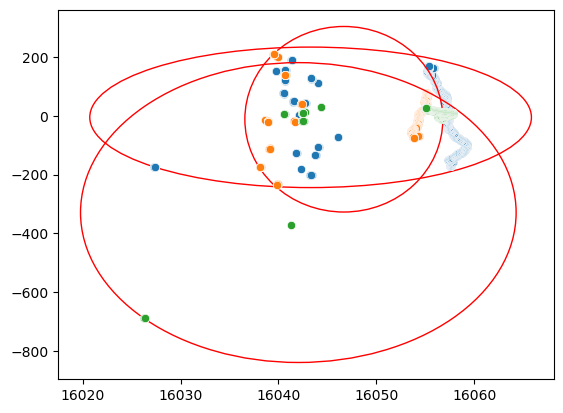

In [21]:
for i in range(1):
    weights,centers,clusters=epasad(df.iloc[:,i].values,i,30)

In [22]:
print(weights)

[array([1.9644117e-03, 1.7550777e-05]), array([9.77593753e-03, 1.00616803e-05]), array([2.01924767e-03, 3.85259625e-06])]


In [23]:
print(clusters)

[array([[16057.5695435 ,  -170.07860967],
       [16057.61568106,  -169.81234155],
       [16057.51088758,  -169.53296758],
       ...,
       [16041.37846938,   190.297462  ],
       [16055.42932893,   169.12062625],
       [16055.43346918,   169.34032695]]), array([[ 1.60551294e+04,  7.66883594e+01],
       [ 1.60551634e+04,  7.65159417e+01],
       [ 1.60551694e+04,  7.62906447e+01],
       [ 1.60552006e+04,  7.60863977e+01],
       [ 1.60551383e+04,  7.58156477e+01],
       [ 1.60551782e+04,  7.55811778e+01],
       [ 1.60551996e+04,  7.53113833e+01],
       [ 1.60552215e+04,  7.51066707e+01],
       [ 1.60552092e+04,  7.48786279e+01],
       [ 1.60552651e+04,  7.47083534e+01],
       [ 1.60551453e+04,  7.42375461e+01],
       [ 1.60551401e+04,  7.39677345e+01],
       [ 1.60551504e+04,  7.37018788e+01],
       [ 1.60551415e+04,  7.33654258e+01],
       [ 1.60551751e+04,  7.31745679e+01],
       [ 1.60551088e+04,  7.29116806e+01],
       [ 1.60550607e+04,  7.24909222e+01],
       [

In [24]:
max_radiis=[]
for i in range(3):
    var1=np.square(clusters[i]-centers[i])
    var2=np.matmul(weights[i],var1.T)
    max_radius=np.amax(var2)
    max_radiis.append(max_radius)
max_radiis

[1.0000001391136095, 0.9999997363378712, 1.0001297963659956]

In [ ]:
testdata=pd.read_csv('data/testdata.csv')
testdata

: 

In [ ]:
y_actual=testdata['Attack LABLE (1:No Attack, -1:Attack)'].tolist()

: 

In [ ]:
y_actual

: 

In [ ]:
testdata = testdata.iloc[:, sensors]
testdata

: 

: 